In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import ConnectionPatch, ArrowStyle

from model import configuration

In [2]:
deaths_ref = configuration.load_deaths_list('Spain')
deaths_ref = configuration.smooth_deaths_list(deaths_ref).get()
# config_ref = configuration.read_configuration('Spain', prefix='used/', sufix='')


In [3]:
MAX_DAYS = 150

Sh = np.zeros(MAX_DAYS)
S = np.zeros(MAX_DAYS)
E = np.zeros(MAX_DAYS)
I = np.zeros(MAX_DAYS)
R = np.zeros(MAX_DAYS)
Pd = np.zeros(MAX_DAYS)
D = np.zeros(MAX_DAYS)
D_historial = np.zeros(MAX_DAYS)


N = 46754778
i_initial = N*1.511855125719048e-06

betta = 0.07
permeability = 0.05
k_confined = 3
k_active = 12
mu = 0.24
eta = 0.2
IFR = 0.01
xi = 0.1
sigma = 2.5

def secure_home(i, n):
    return np.power((1-i/n), sigma-1)

def p_infeccion(i, n, k):
    return 1- np.power((1- betta*i/n), k)

def variations(sh, s, e, i, pd, d, r, p_active):
    St = sh + s
    N = sh + s + e + i + pd + r + d

    P_cont = p_active * p_infeccion(i,N, k_active) + (1-p_active)* (1-secure_home(i,N)*(1-permeability))*p_infeccion(i,N, k_confined)
    _sh = St * (1-p_active)*secure_home(i,N)*(1-permeability)
    return (
        _sh, 
        (St-_sh) - St * P_cont, 
        -eta*e + St * P_cont, 
        -mu*i + eta*e,
        mu*IFR*i + -xi*pd,
        xi*pd,
        mu*(1-IFR)*i
        )
    # return (
    #     _sh, 
    #     St - St * P_cont, 
    #     -eta*e + St * P_cont, 
    #     -mu*i + eta*e,
    #     mu*IFR*i + -xi*pd,
    #     xi*pd,
    #     mu*(1-IFR)*i
    #     )


P_active = np.ones(MAX_DAYS)


def get_trayectories(P_active):
    Sh = np.zeros(MAX_DAYS)
    S = np.zeros(MAX_DAYS)
    E = np.zeros(MAX_DAYS)
    I = np.zeros(MAX_DAYS)
    R = np.zeros(MAX_DAYS)
    Pd = np.zeros(MAX_DAYS)
    D = np.zeros(MAX_DAYS)
    D_historial = np.zeros(MAX_DAYS)

    I[0] = i_initial
    S[0] = N-i_initial

    for t in range(MAX_DAYS-1):
        c = variations(Sh[t], S[t], E[t], I[t], Pd[t], D[t], R[t], P_active[t])

        Sh[t+1]   = c[0] 
        S[t+1]    = c[1]
        # S[t+1]    = c[1]  
        E[t+1]    = E[t]  + c[2] 
        I[t+1]    = I[t]  + c[3] 
        Pd[t+1]   = Pd[t] + c[4] 
        D[t+1]    = c[5] 
        R[t+1]    = R[t]  + c[6]

        D_historial[t+1] = D_historial[t] + c[5]

    return Sh, S, E, I, R, Pd, D, D_historial

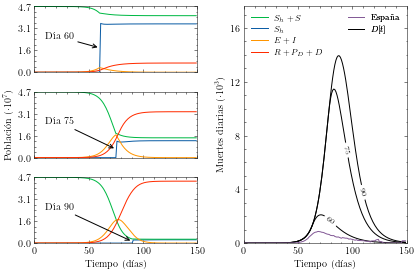

In [4]:
permeability = 0.05
with plt.style.context('science'):
    nrows = 3
    ncols = 2

    fig, ax = plt.subplots(nrows, ncols, sharex=True, figsize=(2*nrows, 2*ncols), tight_layout=True)#, constrained_layout=True)
    gs = ax[0, 1].get_gridspec()

    for axi in ax[0:, -1]:
        axi.remove()

    axm = fig.add_subplot(gs[0:, -1]) 

    # print(ax)
    # exit()

    DELTA_DIAS = 15
    CONST = 7
    for i in range(nrows):

        P_active = np.ones(MAX_DAYS)
        P_active[60+i*DELTA_DIAS:] = 0.1

        Sh, S, E, I, R, Pd, D, D_historial = get_trayectories(P_active)

        l_sh, = ax[i][0].plot(Sh, label=r'$S_h$', color='#0C5DA5')
        l_s, = ax[i][0].plot(S+Sh, label=r'$S_h+S$', color='#00B945')
        l_e, = ax[i][0].plot(E+I, label=r'$E+I$', color='#FF9500')
        l_r, = ax[i][0].plot(R+Pd+D_historial, label=r'$R+P_D+D$', color='#FF2C00')




        ax[i][0].annotate(f"Día {60+i*DELTA_DIAS:d}", xy=(60+i*DELTA_DIAS, Sh.max()/2), xycoords='data',
            xytext=(10, N/2), textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))

        
        l_m, = axm.plot(D, label='$D[t]$', color='black')
        axm.set_ylabel("Muertes diarias ($\cdot 10^3$)")
        axm.set_xlabel("Tiempo (días)")

        if i==nrows-1:
            m_españa, = axm.plot(np.arange(len(S)), deaths_ref[:len(S)], label='España', color='#845B97', zorder=10)
            
            axm.set_yticks(ticks= np.linspace(0, 16000, 5, dtype=int), labels=list(map(lambda x: f"{int(x)}", np.linspace(0, 16, 5))))
        
        if i==nrows-1:
            # ax[i][ncols-1].set_axis_off()
            legend1 = plt.legend(handles=[l_s , l_sh,  l_e , l_r], loc='upper left', fontsize='small')
            legend2 = plt.legend(handles=[m_españa, l_m], loc='upper right', fontsize='small')

            axm.add_artist(legend1)
            axm.add_artist(legend2)
            # axm.legend(handles=[m_españa, l_m], loc='upper left', fontsize='small')# bbox_to_anchor=(1.6, 0.6))

        text = axm.text(80+i*DELTA_DIAS, D[80+i*DELTA_DIAS], f"{60+i*DELTA_DIAS:d}", transform=axm.transData, backgroundcolor='w', fontsize='x-small',
                ha='center', va='center', 
                linespacing=0.5,
                rotation=int(180*np.arctan((D[80+i*DELTA_DIAS]-D[79+i*DELTA_DIAS])*150/16000)/np.pi))


        if i==1:
            ax[i][0].set_ylabel(f"Población ($\cdot 10^{CONST}$)")

        if i==nrows-1:
            ax[i][0].set_xlabel("Tiempo (días)")
        

        ax[i][0].set_yticks(ticks= np.linspace(0, N, 4, dtype=int), labels=list(map(lambda x: f"{x:.1f}", np.linspace(0, 1, 4)*N/(10**CONST))))
        # plt.gcf().text(0.1, 0.9, f"$\cdot 10^{CONST}$")
        # ax[i][0].legend()
        ax[i][0].set_xlim(0, len(S))
        ax[i][0].set_ylim(0, N)
    axm.set_ylim(ymin=0, ymax=axm.get_ylim()[1]*1.1)
    axm.set_xlim(0, len(S))

    

    plt.show()
    fig.savefig("images/our_model_tiempo_escalon.pdf")

[0.24 1.48 2.56] 20875361.973735802
[0.24 1.48 2.56] 15518728.303238302
[0.24 1.48 2.56] 10319922.239267375


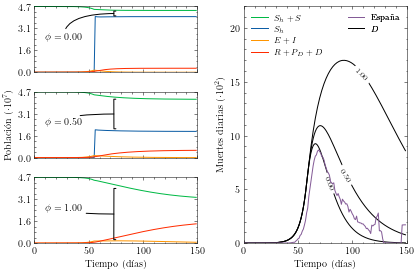

In [5]:

P_active = np.ones(MAX_DAYS)
P_active[55:] = 0.1

with plt.style.context('science'):
    nrows = 3
    ncols = 2

    fig, ax = plt.subplots(nrows, ncols, sharex=True, figsize=(2*nrows, 2*ncols), tight_layout=True)#, constrained_layout=True)
    gs = ax[0, 1].get_gridspec()

    for axi in ax[0:, -1]:
        axi.remove()

    axm = fig.add_subplot(gs[0:, -1]) 
    


    # print(ax)
    # exit()

    DELTA_DIAS = 15
    CONST = 7
    for i in range(nrows):



        permeability = 0 + 0.5*i

        Sh, S, E, I, R, Pd, D, D_historial = get_trayectories(P_active)

        l_sh, = ax[i][0].plot(Sh, label=r'$S_h$', color='#0C5DA5')
        l_s, = ax[i][0].plot(S+Sh, label=r'$S_h+S$', color='#00B945')
        l_e, = ax[i][0].plot(E+I, label=r'$E+I$', color='#FF9500')
        l_r, = ax[i][0].plot(R+Pd+D_historial, label=r'$R+P_D+D$', color='#FF2C00')

        width = np.array([0.3, 1.85, 3.2])

        width *= 2/2.5

        print(width, (S[75]+ 2*Sh[75])/4)
        arrstyle = ArrowStyle("-[",
            widthB=width[i],
            lengthB=0.2,
            angleB=0
        ) 
        

        ax[i][0].annotate(f"$\\phi ={permeability:.2f}$", xy=(75, (S[75]+ 2*Sh[75])/2), xycoords='data',
            xytext=(10, N/2), textcoords='data', arrowprops=dict(arrowstyle=arrstyle, connectionstyle='angle3'))


        l_m, = axm.plot(D, label='$D$', color='black')
        axm.set_ylabel("Muertes diarias ($\cdot 10^2$)")
        axm.set_xlabel("Tiempo (días)")

        if i==nrows-1:
            # ax[i][ncols-1].set_axis_off()
            legend1 = plt.legend(handles=[l_s , l_sh,  l_e , l_r], loc='upper left', fontsize='small')
            legend2 = plt.legend(handles=[m_españa, l_m], loc='upper right', fontsize='small')

            axm.add_artist(legend1)
            axm.add_artist(legend2)
            # axm.legend(handles=[m_españa, l_m], loc='upper left', fontsize='small')# bbox_to_anchor=(1.6, 0.6))

        if i==nrows-1:
            m_españa, = axm.plot(np.arange(len(S)), deaths_ref[:len(S)], label='España', color='#845B97', zorder=10)
            # axm.legend(handles=[l_r, m_españa, l_s , l_e , l_sh,  l_m], loc='upper left')# bbox_to_anchor=(1.6, 0.6))

            axm.set_yticks(ticks= np.linspace(0, 2000, 5, dtype=int), labels=list(map(lambda x: f"{int(x)}", np.linspace(0, 20, 5))))
        
        if i==1:
            ax[i][0].set_ylabel(f"Población ($\cdot 10^{CONST}$)")

        text = axm.text(79+i*DELTA_DIAS, D[80+i*DELTA_DIAS], f"{permeability:.2f}", transform=axm.transData, backgroundcolor='w', fontsize='x-small',
                ha='center', va='center', 
                linespacing=0.5,
                rotation=np.arctan2((D[80+i*DELTA_DIAS]-D[79+i*DELTA_DIAS])*150, 2000) * 180/np.pi
                )



        if i==nrows-1:
            ax[i][0].set_xlabel("Tiempo (días)")


        ax[i][0].set_yticks(ticks= np.linspace(0, N, 4, dtype=int), labels=list(map(lambda x: f"{x:.1f}", np.linspace(0, 1, 4)*N/(10**CONST))))
        # plt.gcf().text(0.1, 0.9, f"$\cdot 10^{CONST}$")
        # ax[i][0].legend()
        ax[i][0].set_xlim(0, len(S))
        ax[i][0].set_ylim(0, N)
    axm.set_ylim(ymin=0, ymax=axm.get_ylim()[1]*1.1)
    axm.set_xlim(0, len(S))
    plt.show()
    fig.savefig("images/our_model_permeability.pdf")